In [1]:
# Import Libraries
import numpy as np

from project_utils.bb_model         import BB_Model
from project_utils.feature_stats    import Feature_Statistics_R
from project_utils.feature_stats    import Regression_Container
from project_utils.acq_data_capture import Acq_Data_nD
from project_utils.surroagte_gp     import Surrogate_GP



In [2]:
Num_Points    = 30
Title         = 'Concrete'
FUR_Weight    = 0.2
N_consistancy = 25
consist_bound = 0.3

In [3]:
if isinstance(FUR_Weight, float):
    FUR_Weight = [FUR_Weight, 1.0 - FUR_Weight]
    
print(FUR_Weight)

[0.2, 0.8]


In [4]:
Title = Title + ' W:'+ str(FUR_Weight)

In [5]:
# Load Forrester model

Reg_Data = BB_Model(dataset = 'Concrete', Feature_Counts=[16,12])

#Reg_Data.df().head()

In [6]:
Reg_Data.MPL()

0.5250025921641706


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(random_state=RandomState(MT19937) at 0x1DD06219A40)

In [7]:
Reg_Data.Random_Forest()

0.7849411013559787


RandomForestRegressor(random_state=RandomState(MT19937) at 0x1DD06219A40)

In [8]:
Reg_Data.GP()

-6.199396868412322


GaussianProcessRegressor()

In [9]:
Reg_Data.L_Regression()

0.7025323384037439


LinearRegression()

In [10]:
print(Reg_Data.get_features())

['crime_rate', 'zoned_lots', 'industry', 'by_river', 'NOX', 'avg_rooms', 'pre_1940', 'emp_distance', 'rad_access', 'tax_rate', 'pupil_tea_rat', 'bk', 'low_status']


In [11]:
#Default settings
from unravel_2.ur_model import UR_Model

X_train, X_test, y_train, y_test = Reg_Data.get_TT_data()

#Initializing the explainer object
URM_Exp = UR_Model(bbox_model           = Reg_Data.get_Random_Forest(),
                   train_data           = X_train,
                   feature_names        = Reg_Data.get_features(),
                   categorical_features = Reg_Data.get_catagorical(),
                   mode                 = Reg_Data.get_mode(),
                   sampling_optimize    = "opt")

#sur_GP = Surrogate_GP()


In [12]:
#I2nd explainer object
URM_Exp_2 = UR_Model(bbox_model           = Reg_Data.get_L_Regression(),
                     train_data           = X_train,
                     feature_names        = Reg_Data.get_features(),
                     categorical_features = Reg_Data.get_catagorical(),
                     mode                 = Reg_Data.get_mode(),
                     sampling_optimize    = "opt")



In [13]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
print('Mean 0:', mean)
print('Std 0: ', std)


Mean 0: [1.37920922e+00 1.18878116e+01 1.03077562e+01 7.20221607e-02
 5.42010249e-01 6.34069529e+00 6.62673130e+01 4.01567479e+00
 7.80886427e+00 3.77889197e+02 1.82648199e+01 3.35476676e+02
 1.12813296e+01]
Std 0:  [2.41455849e+00 2.25291874e+01 6.61673918e+00 2.58524600e-01
 1.12419410e-01 6.65873534e-01 2.74928525e+01 2.01987976e+00
 7.44319422e+00 1.49316611e+02 2.20375103e+00 1.23006489e+02
 5.75922725e+00]


In [14]:
# Generate explantion data for Random Forest

Reg_Stats   = Feature_Statistics_R(feature_names = Reg_Data.get_features(),
                                   mode          = Reg_Data.get_mode(),
                                   X_train_std   = Reg_Data.get_X_train_std(),
                                   N_consistancy = N_consistancy)

Reg_Stats_2 = Feature_Statistics_R(feature_names = Reg_Data.get_features(),
                                   mode          = Reg_Data.get_mode(),
                                   X_train_std   = Reg_Data.get_X_train_std())


if Num_Points > X_test.shape[0]: Num_Points = X_test.shape[0]

elif Num_Points == 0:            Num_Points = X_test.shape[0]

for test_instance in range(Num_Points):

    print('INSTANCE: ', test_instance)
       
    data_row  = np.array([X_test[test_instance]])
    
#    data_row  = np.array([0.4])

#    print('data row ',data_row)
    
    URM_Exp.explain(X_init      = data_row.reshape(1, -1),
                    Dimension   = 'Multi D',
                    kernel_type = "Matern",
                    max_iter    = 20,
                    alpha       = "FUR_W",
                    #jitter=5,
                    interval    = 1,
                    weight      = FUR_Weight)
       
    f_predict = Reg_Data.get_Random_Forest().predict(data_row.reshape(1, -1))

    e_predict = URM_Exp.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    acq_data = URM_Exp.get_acq_data()
    
#    X, y = URM_Exp.get_surrogate_data()

#    e_predict = sur_GP.predict(X, y)
#    e_predict = sur_GP.predict(URM_Exp.get_surrogate_data())

    print(f_predict, e_predict, acq_data.get_fe_x0())
    
    scores = URM_Exp.permutation_importance()
    
    consistancy = URM_Exp.Y_Consistancy(N_points = N_consistancy, std_bound = consist_bound)
    
    URM_Exp.del_1_rel()
    
    del_1_var = URM_Exp.get_del_1_variance()
    
    Reg_Stats.Add_Sample(sample_scores = scores,
                         outcome       = y_test[test_instance],
                         X_row         = data_row.reshape(1, -1),
                         f_prediction  = f_predict,
                         e_prediction  = e_predict.ravel(),
                         feopt         = acq_data.get_fe_x0(),
                         consistancy   = consistancy,
                         del_1_var     = del_1_var)
    
    
    ############################################################################################
    
    URM_Exp_2.explain(X_init      = data_row.reshape(1, -1),
                      Dimension   = 'Multi D',
                      kernel_type = "Matern",
                      max_iter    = 20,
                      alpha       = "FUR_W",
                      #jitter=5,
                      interval    = 1,
                      weight      = FUR_Weight)
       
    f_predict = Reg_Data.get_L_Regression().predict(data_row.reshape(1, -1))

    e_predict = URM_Exp_2.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    scores = URM_Exp_2.permutation_importance()
    
    Reg_Stats_2.Add_Sample(sample_scores = scores,
                           outcome       = y_test[test_instance],
                           X_row         = data_row.reshape(1, -1),
                           f_prediction  = f_predict,
                           e_prediction  = e_predict.ravel(),
                           feopt         = None)
    


INSTANCE:  0
Acq_Data_nD
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 0 False
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS E

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 0 False
Opt iteratio

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 3 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 4 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  1
Acq_Data_nD
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 4 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EX

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  2
Acq_Data_nD
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 0 False
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS E

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 2 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 2 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  3
Acq_Data_nD
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 3 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EX

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 2 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
INSTANCE:  4
Acq_Data_nD
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 2 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EX

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 3 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
INSTANCE:  5
Acq_Data_nD
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 4 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EX

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 2 True


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 4 True


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  6
Acq_Data_nD
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 3 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  8
Acq_Data_nD
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 4 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 4 True
Opt iteration fail:  STOP: TOTAL NO. 

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 3 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
INSTANCE:  9
Acq_Data_nD
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 1 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EX

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 3 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  10
Acq_Data_nD
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 3 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS E

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 4 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  11
Acq_Data_nD
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 4 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS E

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 4 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
INSTANCE:  12
Acq_Data_nD
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteratio

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  13
Acq_Data_nD
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 3 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS E

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 4 True
INSTANCE:  14
Acq_Data_nD
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS E

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
[17.855] [1.78550000e+01 1.00000004e-05] [17.85500001]
Acq_Data_nD
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 3 True
Opt iteration fail: 

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 2 True
INSTANCE:  15
Acq_Data_nD
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS E

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 3 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 3 True


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  16
Acq_Data_nD
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 4 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS E

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 2 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 4 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  17
Acq_Data_nD
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteratio

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  20
Acq_Data_nD
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAI

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 3 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
INSTANCE:  21
Acq_Data_nD
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 3 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS E

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 3 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
INSTANCE:  22
Acq_Data_nD
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 4 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS E

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 3 True


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 4 True
Opt iteration

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. o

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 3 True


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 1 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 2 True
Opt iteration

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 0 False
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteratio

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 2 True
Opt iteration

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 4 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 4 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
[12.976] [1.29760000e+01 1.00000004e-05] [12.976]
Acq_Data_nD
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 2 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
INSTANCE:  28
Acq_Data_nD
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteratio

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 2 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 4 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Optimize FAIL 9 : 4 True
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EX

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. o

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Opt iteration fail:  STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT


In [15]:
import matplotlib.pyplot as plt


In [16]:
print(f_predict)
print(e_predict)


[22.60337769]
[2.26033714e+01 9.80538867e-06]


In [17]:
Reg_Stats.Feature_Counts(max_features=20, scaled=True, threshold=0.05)


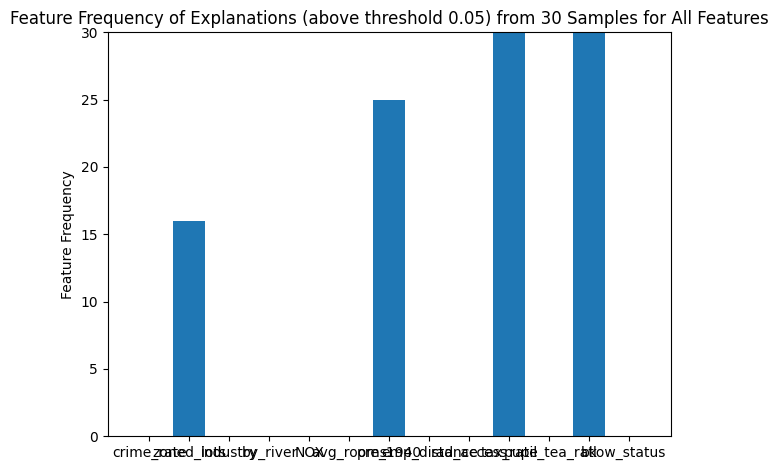

In [18]:
Reg_Stats.Frequency_Plot()


Average, SD, and Max Differences:
y - BB(x):           3.2532666666666668  :  4.5080164591043275  :  24.674999999999983
y - exp(x):          3.2532666640100936  :  4.5080164560558575  :  24.674999981889272
BB(x) - exp(x):      1.066185439195048e-08  :  2.1541079536246212e-08  :  1.1081398554324551e-07
Average exp(x) Uncertainty:  1.000000041370185e-05
R Score:   1.0
Fidelity:  1.0


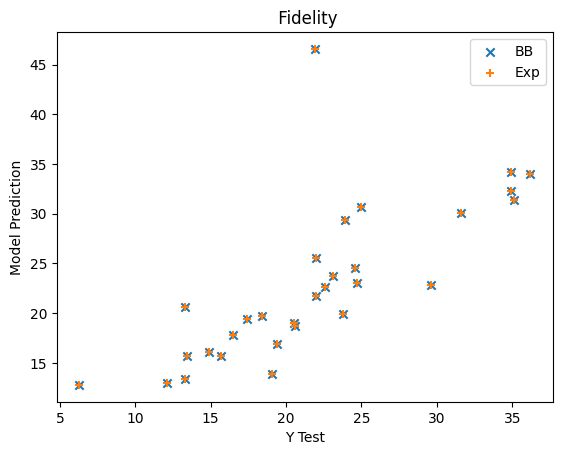

In [19]:
Reg_Stats.Fidelity()

In [20]:
Reg_Stats.Jaccard_Values()

Mean Jaccard Similarity:  1.0
Mean Jaccard Distance:    0.0


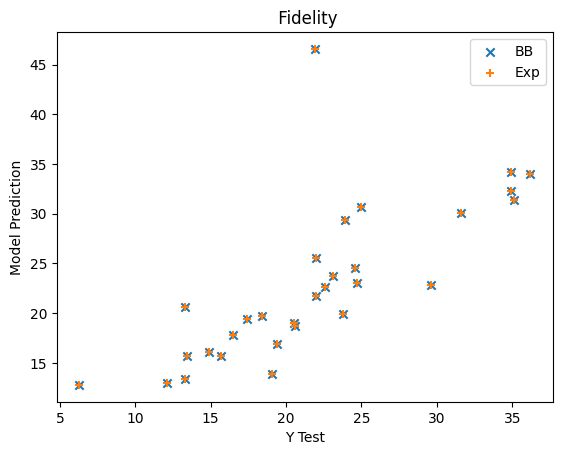

In [21]:
Reg_Stats.Reg_Fidelity_Graph()

top_features True
top_features (30, 13)


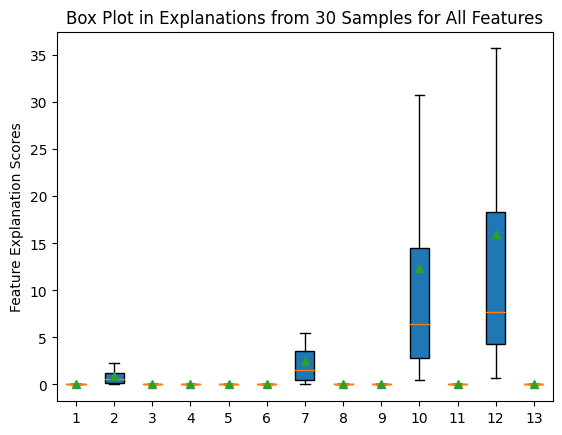

1 -      crime_rate
2 -      zoned_lots
3 -      industry
4 -      by_river
5 -      NOX
6 -      avg_rooms
7 -      pre_1940
8 -      emp_distance
9 -      rad_access
10 -     tax_rate
11 -     pupil_tea_rat
12 -     bk
13 -     low_status


In [22]:
Reg_Stats.Box_Plot()


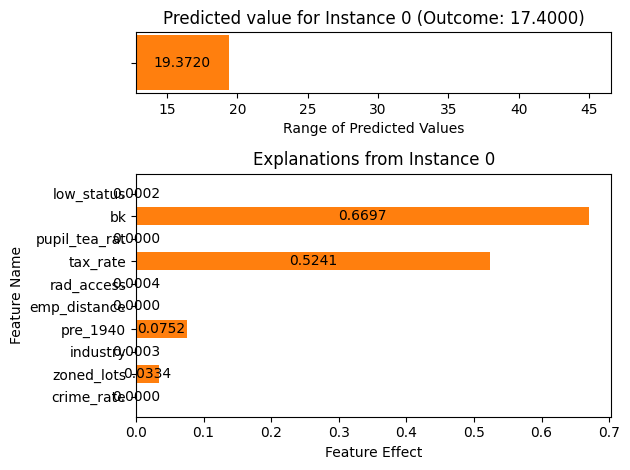

In [23]:
Reg_Stats.View_Explanation(instance = 0)

In [24]:
scores = URM_Exp.permutation_importance()
    
print(scores)

[6.99419950e-04 3.46325573e+00 3.43167254e-02 9.93555153e-08
 3.57199750e-09 4.30789037e-06 9.03390119e+00 3.47426527e-04
 5.35399888e-02 6.56882364e+01 4.89046082e-04 7.99383850e+01
 2.02332542e-02]


In [25]:
scores_k = URM_Exp.KL_imp()

print(scores_k)

[1.82719426 1.85327699 1.8286014  1.82698576 1.8269838  1.82699935
 1.88094243 1.8271309  1.8290432  1.8764776  1.82715907 1.87996665
 1.82820279]


In [26]:
scores_v = URM_Exp.Var_imp()

print(scores_v)

[ 0.23355473  1.05375084  0.2669356   0.22869618  0.22865071  0.22901223
  2.69671178  0.23207582  0.27762067 24.72984358  0.23273269 26.78693611
  0.25736566]


In [27]:
scores_d1 = URM_Exp.del_1_rel()

print(scores_d1)

[1.33009356e-05 0.00000000e+00 6.33599913e-02 0.00000000e+00
 5.19768349e-05 1.18989566e-02 1.44098489e+00 1.57294274e-03
 1.02738417e-03 4.72394236e+00 2.03653410e-01 6.51870736e+00
 3.47874281e-02]


In [28]:
scores_d2 = URM_Exp.del_2_rel()

print(scores_d2)

[2.06310312e-06 4.67522409e-02 1.21412140e-04 1.35641230e-09
 1.12100190e-11 1.37322733e-08 3.57768968e-01 9.75551908e-07
 1.96522496e-04 1.18484588e+01 1.47713300e-06 7.46629171e-01
 6.83912052e-05]


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [29]:
lin_scores = URM_Exp.Lin_scores()

print(lin_scores)

[ 1.40979692e+03  5.48813166e+01 -3.14115868e+03  1.68873453e+04
  3.07236347e+05 -3.83011302e+04 -1.19899659e+01 -1.69749964e+03
  1.00769571e+03 -1.79151000e-02 -1.73156591e+03  2.63543721e-02
  4.87064047e+02]


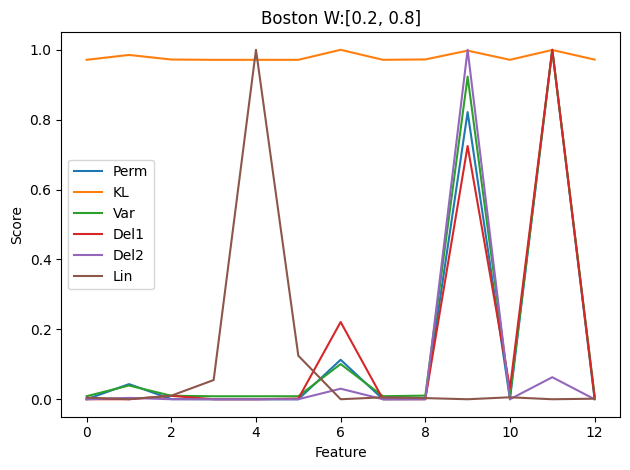

In [30]:
URM_Exp.plot_scores(Title, 'scores_W28.jpg')

In [31]:
print(URM_Exp.get_exp_L())


[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 8.99512095e-01  4.36895858e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 7.34922601e-02 -4.26513380e-02  9.96383335e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.0

In [32]:
acq_data.Create_BB_plot()

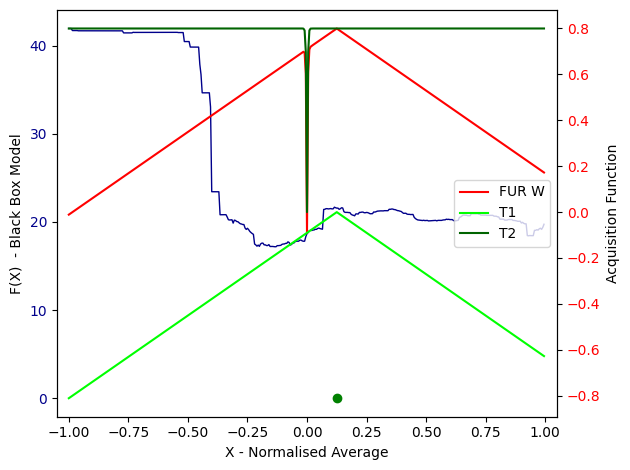

In [33]:
acq_data.plot_point(0)

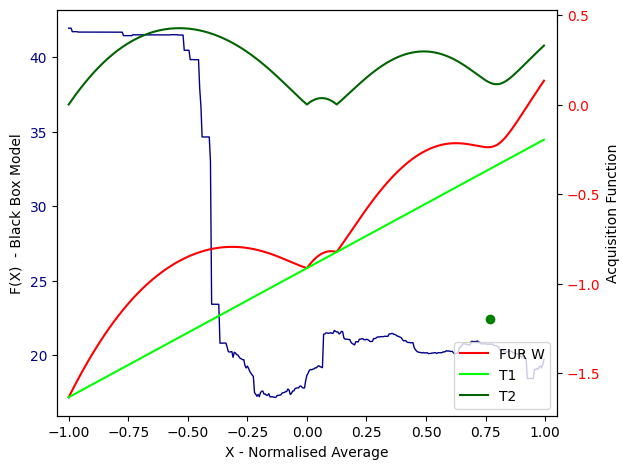

In [34]:
acq_data.plot_point(5)

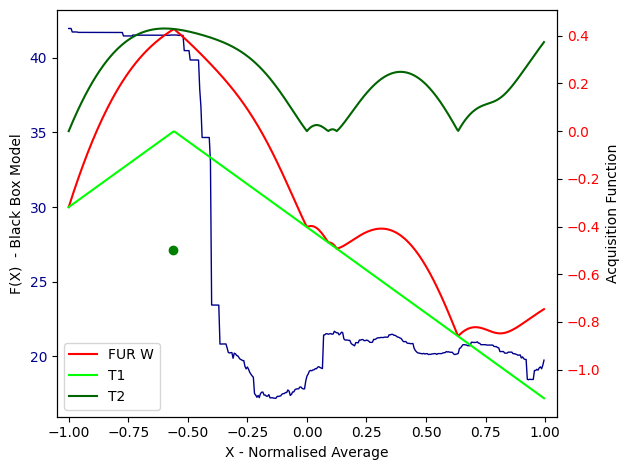

In [35]:
acq_data.plot_point(10)

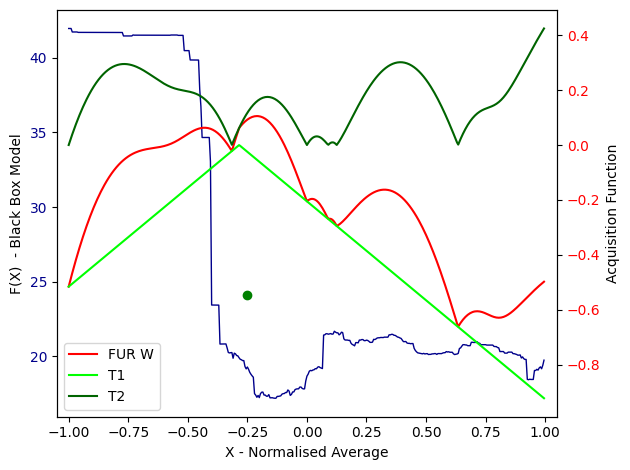

In [36]:
acq_data.plot_point(15)

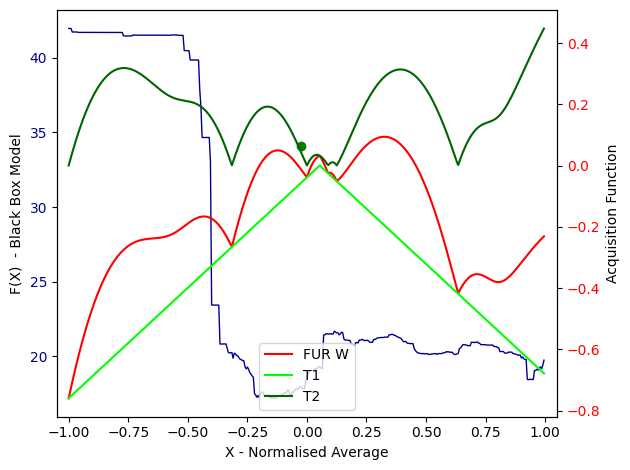

In [37]:
acq_data.plot_point(19)

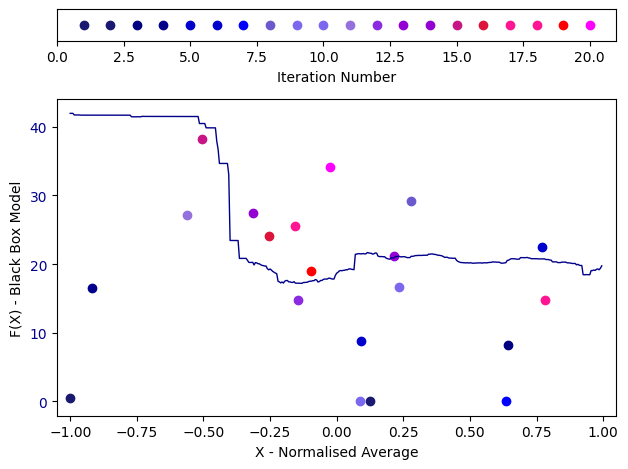

In [38]:
acq_data.plot_all()

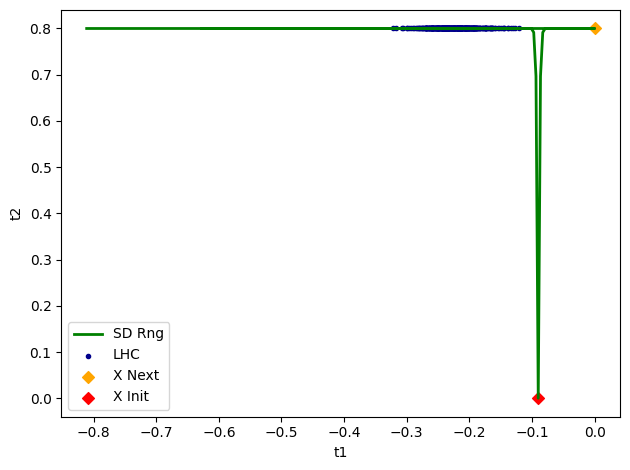

In [39]:
acq_data.plot_t1_t2(0)

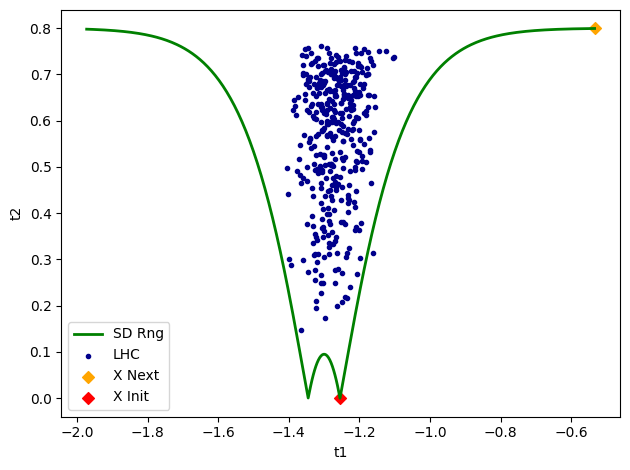

In [40]:
acq_data.plot_t1_t2(1)

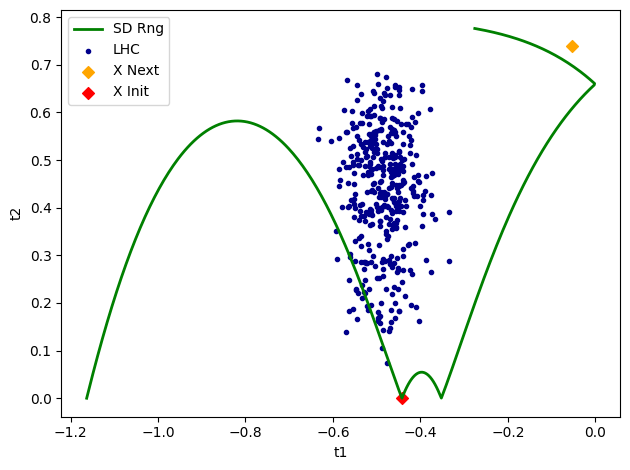

In [41]:
acq_data.plot_t1_t2(2)

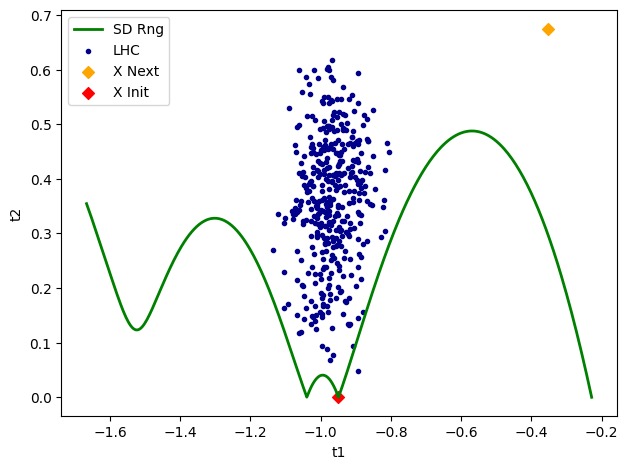

In [42]:
acq_data.plot_t1_t2(3)

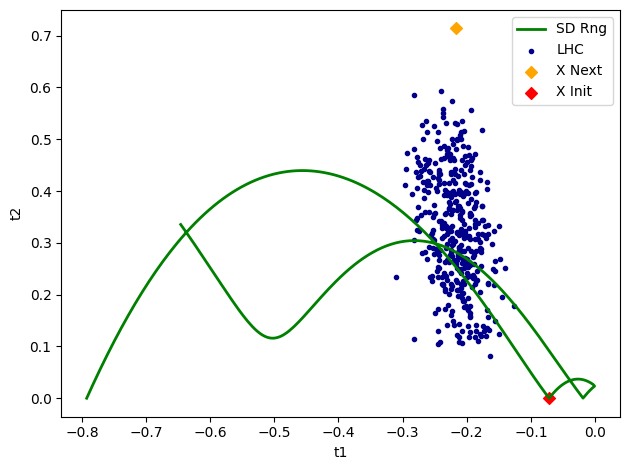

In [43]:
acq_data.plot_t1_t2(4)

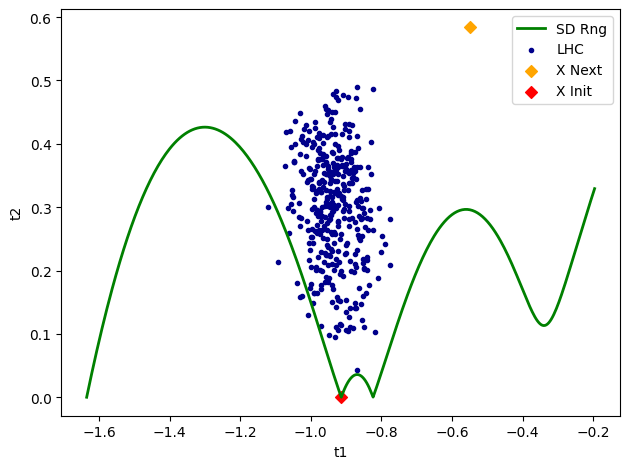

In [44]:
acq_data.plot_t1_t2(5)

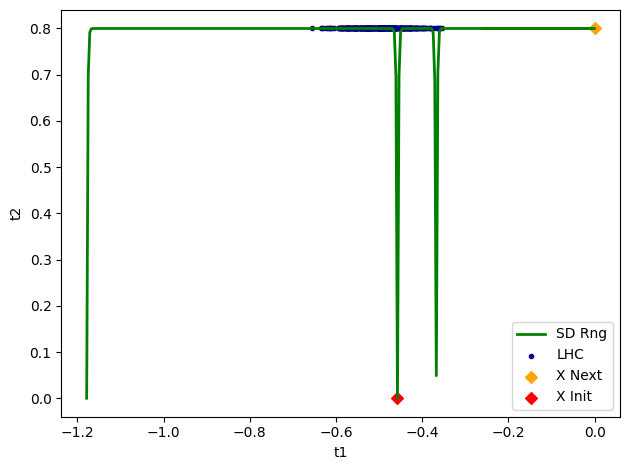

In [45]:
acq_data.plot_t1_t2(6)

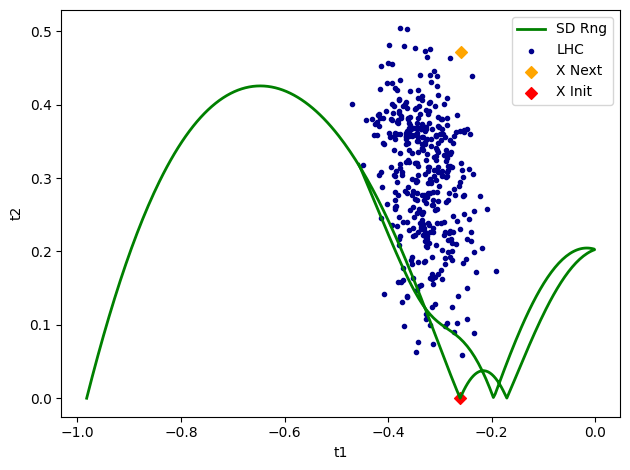

In [46]:
acq_data.plot_t1_t2(7)

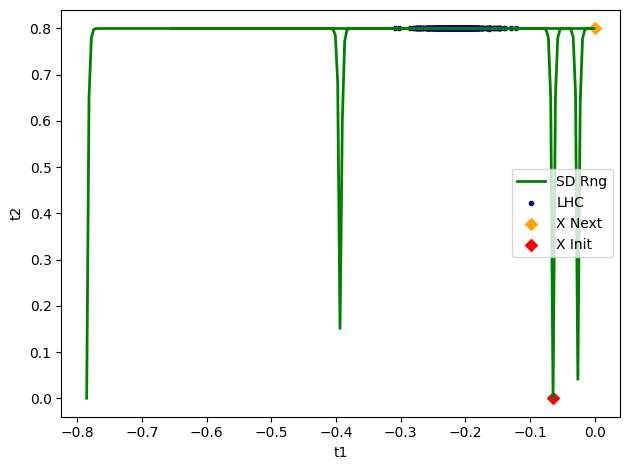

In [47]:
acq_data.plot_t1_t2(8)

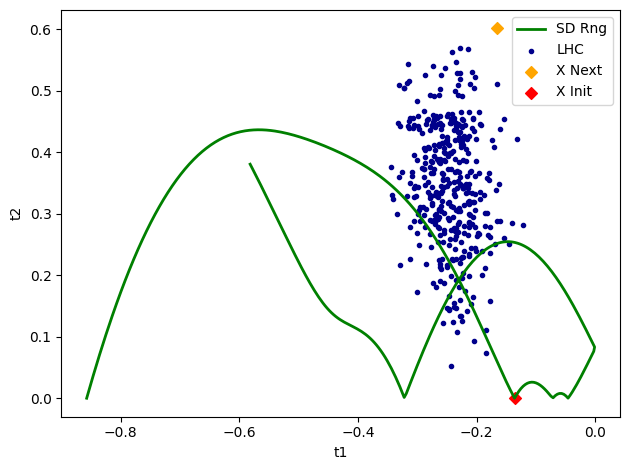

In [48]:
acq_data.plot_t1_t2(9)

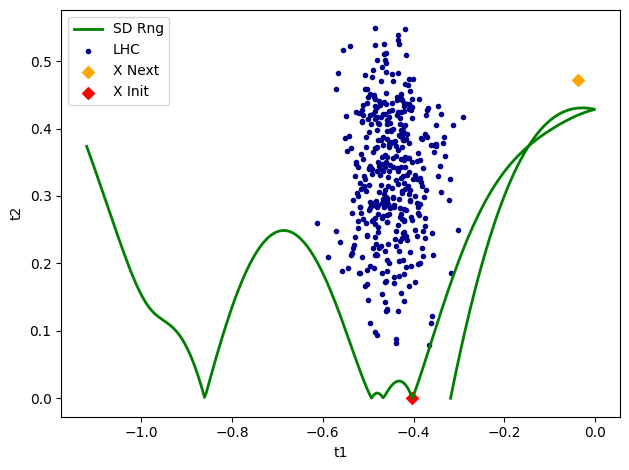

In [49]:
acq_data.plot_t1_t2(10)

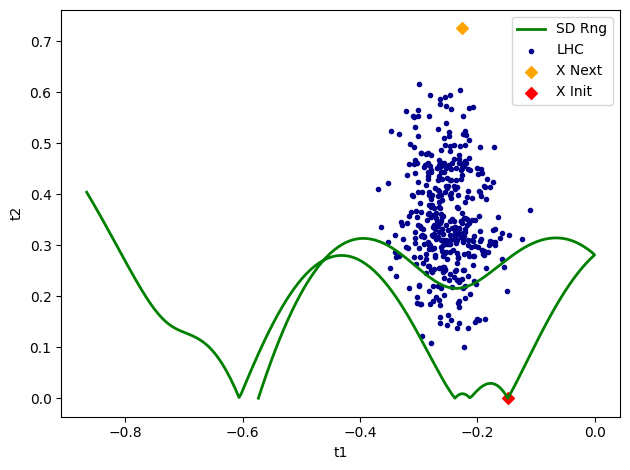

In [50]:
acq_data.plot_t1_t2(11)

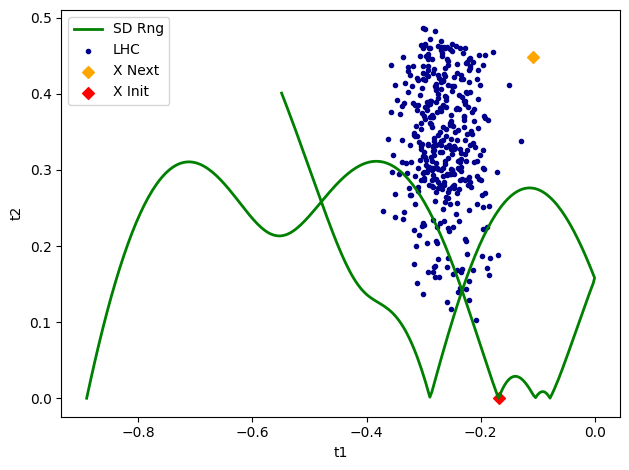

In [51]:
acq_data.plot_t1_t2(12)

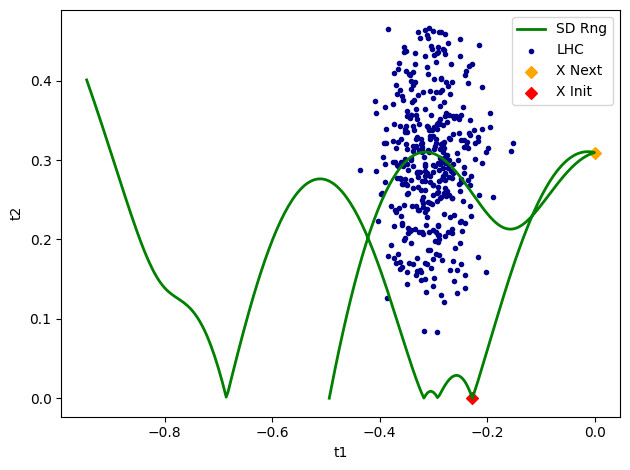

In [52]:
acq_data.plot_t1_t2(13)

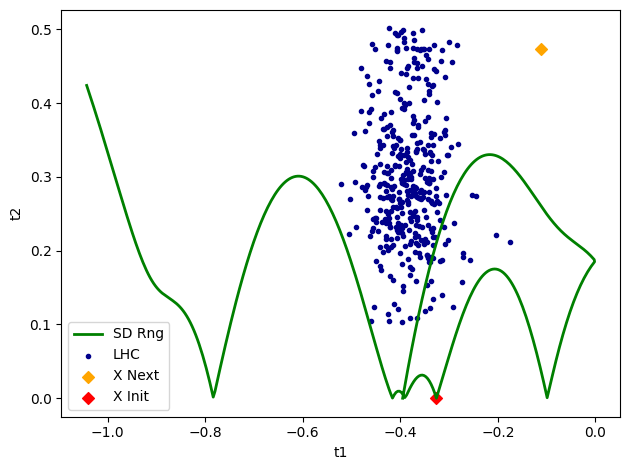

In [53]:
acq_data.plot_t1_t2(14)

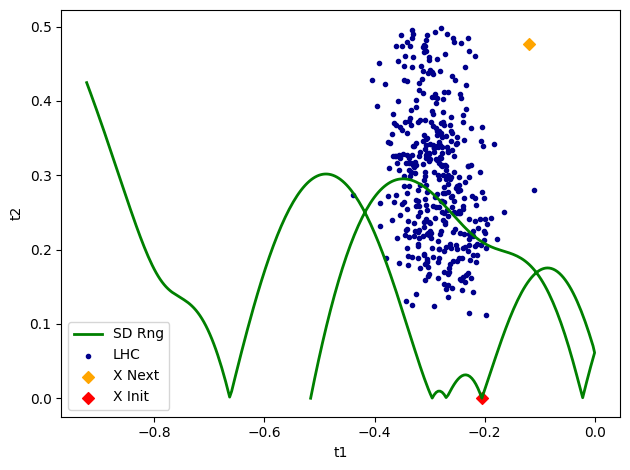

In [54]:
acq_data.plot_t1_t2(15)

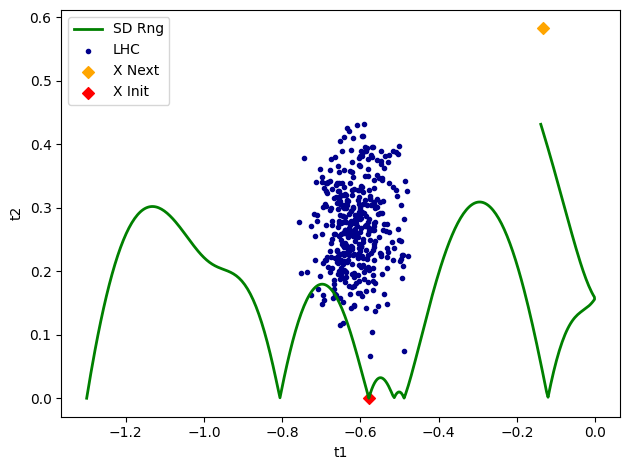

In [55]:
acq_data.plot_t1_t2(16)

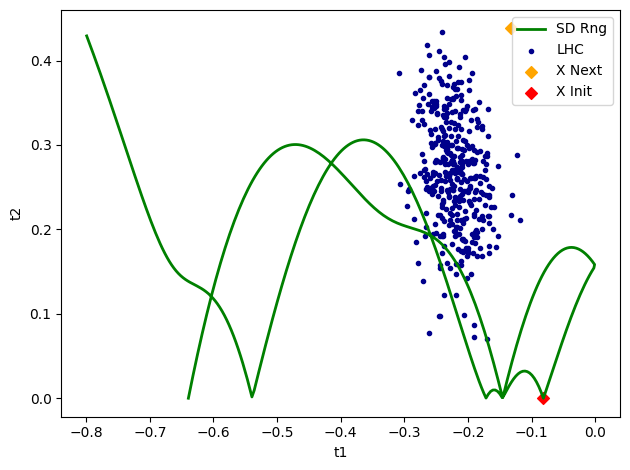

In [56]:
acq_data.plot_t1_t2(17)

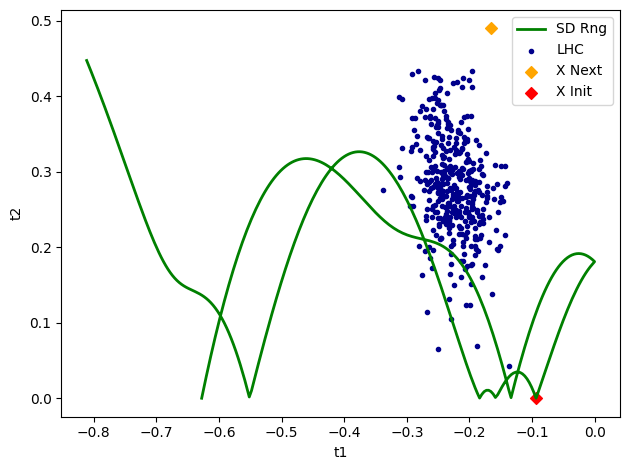

In [57]:
acq_data.plot_t1_t2(18)

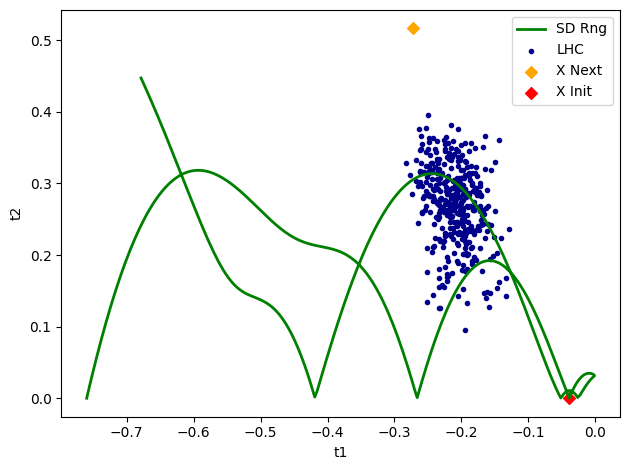

In [58]:
acq_data.plot_t1_t2(19)

Average, SD, and Max Differences:
y - BB(x):           3.2532666666666668  :  4.5080164591043275  :  24.674999999999983
y - exp(x):          3.2532666640100936  :  4.5080164560558575  :  24.674999981889272
BB(x) - exp(x):      1.066185439195048e-08  :  2.1541079536246212e-08  :  1.1081398554324551e-07
Average exp(x) Uncertainty:  1.000000041370185e-05
R Score:   1.0
Fidelity:  1.0


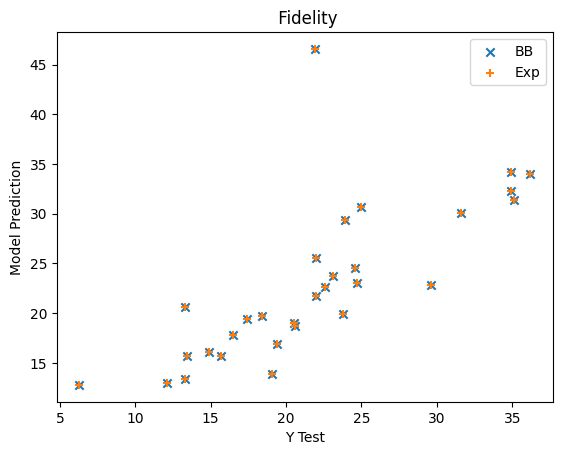

Fidelity:  0.9999999997616404


In [59]:
Reg_Stats.Fidelity()

print('Fidelity: ', Reg_Stats.fidelity)

In [60]:
Reg_Stats.Jaccard_Values(top_k=4)

print('Jaccard: ', Reg_Stats.jaccard_similarities)

Mean Jaccard Similarity:  1.0
Mean Jaccard Distance:    0.0
Jaccard:  1.0


N_Points:  25


C:\Users\deneb\MSc_Project\MSc_Project\MSc_project\Project_5_boston\project_utils\feature_stats.py:849: RuntimeWarning: divide by zero encountered in divide
  y_uncert_all = y_uncert_all + y_uncert / y_mid
C:\Users\deneb\MSc_Project\MSc_Project\MSc_project\Project_5_boston\project_utils\feature_stats.py:849: RuntimeWarning: invalid value encountered in divide
  y_uncert_all = y_uncert_all + y_uncert / y_mid
C:\Users\deneb\MSc_Project\MSc_Project\MSc_project\Project_5_boston\project_utils\feature_stats.py:855: RuntimeWarning: divide by zero encountered in divide
  y_pert_all = y_pert_all + ((y_pert - y_mid) / y_mid)
C:\Users\deneb\MSc_Project\MSc_Project\MSc_project\Project_5_boston\project_utils\feature_stats.py:855: RuntimeWarning: invalid value encountered in divide
  y_pert_all = y_pert_all + ((y_pert - y_mid) / y_mid)
C:\Users\deneb\MSc_Project\MSc_Project\MSc_project\Project_5_boston\project_utils\feature_stats.py:849: RuntimeWarning: invalid value encountered in add
  y_uncert_al

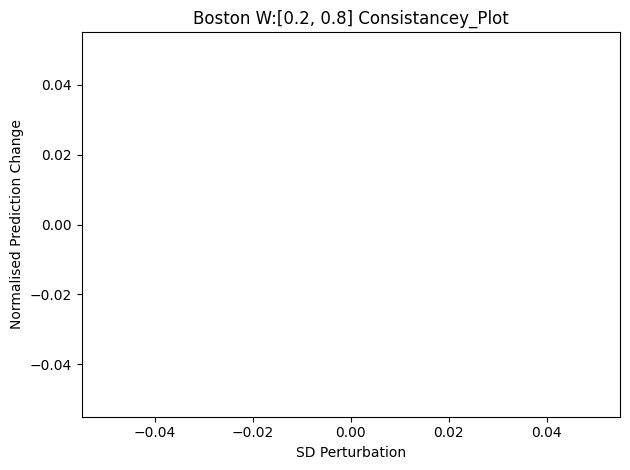

In [63]:
Reg_Stats.Consistancy(std_bound = consist_bound, plot=True, title = Title)

In [64]:
Reg_Stats.Compare_Models (model_b = Reg_Stats_2)

mean_scores:  [1.33770116e-04 8.79553882e-01 6.89518700e-03 1.85600900e-08
 6.66312736e-10 8.08167882e-07 2.50382952e+00 6.61401760e-05
 1.08705727e-02 1.23639374e+01 9.32937257e-05 1.59930696e+01
 4.02398118e-03]
mean_scores_d:  [7.78810273e-07 5.55540426e-03 4.14879262e-05 1.03561984e-10
 3.77115728e-12 4.52234362e-09 1.43467972e-02 3.86156182e-07
 7.26389955e-05 9.62639928e-01 5.38196426e-07 1.00906490e-01
 2.54940509e-05]
Score Diff Mean:  [0.98842339 0.98744696 0.98803809 0.98890228 0.98874422 0.98887068
 0.98860541 0.98839088 0.98672437 0.85553081 0.9885285  0.98746034
 0.98740871]
Score Diff SD:    [1.52463709 1.25120616 1.4831509  1.54327667 1.54412138 1.54007317
 1.17133345 1.52843545 1.47305474 1.15036681 1.52672593 1.25862554
 1.49153857]
 Model Feature Correlation:  0.6447543063367202


Calibration MSE/MAE 0.5226415502648412 0.5905906401891545


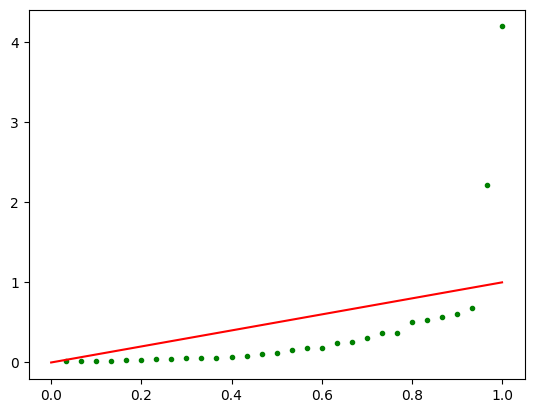

In [65]:
Reg_Stats.Regression_Calibration(plot=True, title=Title)

In [66]:
print(Reg_Stats.calibration_MAE)

0.5905906401891545


In [67]:
Reg_Stats.Regression_Calibration_2(plot=True, title=Title)

root_mean_squared_calibration_error:  0.5701024776448835
mean_absolute_calibration_error:  0.49


In [68]:
Reg_Stats.add_bb_del_1(Reg_Data.Random_Forest())
Reg_Stats.delete_one()

mean_variance [1.17318041e-02 1.12267448e+00 1.42198491e-01 2.71113502e-05
 3.25407437e-04 3.62133544e-02 2.78574683e+00 2.19880041e-02
 1.44374585e-01 1.30585141e+01 2.48867624e-01 1.52890852e+01
 1.34682651e-01]
Mean scores: [1.33770116e-04 8.79553882e-01 6.89518700e-03 1.85600900e-08
 6.66312736e-10 8.08167882e-07 2.50382952e+00 6.61401760e-05
 1.08705727e-02 1.23639374e+01 9.32937257e-05 1.59930696e+01
 4.02398118e-03]
sort_order [ 4  3  5  7 10  0 12  2  8  1  6  9 11]
norm sorted_scores [2.72713817e-10 7.59642237e-09 3.30773428e-07 2.70703813e-05
 3.81840038e-05 5.47505050e-05 1.64696727e-03 2.82211740e-03
 4.44919510e-03 3.59990862e-01 1.02478741e+00 5.06041140e+00
 6.54577170e+00]
norm sorted_variance [1.28204679e-04 1.06813845e-05 1.42674105e-02 8.66287826e-03
 9.80493692e-02 4.62211987e-03 5.30625430e-02 5.60236488e-02
 5.68809907e-02 4.42313557e-01 1.09753416e+00 5.14481976e+00
 6.02362468e+00]
Prediction Variance Feature Deletion 1: [1.17318041e-02 1.12267448e+00 1.42198491

In [69]:
Reg_Stats.Results_Summary(Title)

Results_Summary: Concrete W:[0.2, 0.8]
Timestamp:  2023-05-13 14:54:07.859470
 Model Feature Correlation:  0.6447543063367202
R Score:   1.0
Fidelity:  1.0
Consistancey Std/Y Pert:  0.3 : nan
Delete 1 error:       0.0803303118651003
Delete 1 Correlation: 0.9984071685507145
Mean Jaccard Similarity:  1.0
Mean Jaccard Distance:    0.0
Calibration MSE/MAE:  0.5226415502648412 : 0.5905906401891545
 Model Feature Correlation:  0.6447543063367202
